In [1]:
import sys
import logging
import concurrent.futures
import time
from datetime import datetime
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import Transformer, CRS
from shapely.geometry import Polygon, Point
from sliderule import icesat2
from sliderule import sliderule
import re
import datetime
import numpy as np
import shapely

'3.6.0'

In [3]:
import matplotlib
#matplotlib.use('agg')
%matplotlib inline


In [4]:
%matplotlib widget

## Initialize Sliderule

In [5]:
# Configure Session #
#icesat2.init("icesat2sliderule.org", True)
icesat2.init("slideruleearth.io", True) #doesn't work
asset = 'nsidc-s3'
sliderule.__version__

'3.6.0'

# define a search polygon

In [6]:
latR=[-67.5, -64.5]
lonR=[59.6, 67.7]

poly=[{'lat':latR[ii], 'lon':lonR[jj]} for ii, jj in zip([1, 1, 0, 0, 1], [1, 0, 0, 1, 1])]

## Generate ATL06-type segments using the ATL03-native photon classification

Use the ocean classification for photons with a confidence parmeter to 2 or higher (low confidence or better)

In [7]:

params={'srt': 1,  # Ocean classification
 'len': 10,        # 10-meter segments
 'ats':5,          # require that each segment contain photons separated by at least 5 m
 'res':5,          # return one photon every 5 m
 'track': 0,       # return all ground tracks
 'pass_invalid': True,   
 'cnf': 2,         # require classification confidence of 2 or more
 'iterations':10,  # iterate the fit
 't0': '2019-05-02T02:12:24',  # time range (not needed in this case)
 't1': '2019-05-02T03:00:00',
 'poly': poly   # polygon within which to select photons
}

# Run the parallel version of the ATL06 algorithm, for a specified granule:

gdf_sea_ice_2 = icesat2.atl06p(params, asset="nsidc-s3", resources=['ATL03_20190502021224_05160312_005_01.h5'])


INFO:sliderule.sliderule:request <AppServer.42731> processing initialized on ATL03_20190502021224_05160312_005_01.h5 ...
INFO:sliderule.sliderule:request <AppServer.42731> processing of ATL03_20190502021224_05160312_005_01.h5 complete (591279/0/0)
INFO:sliderule.sliderule:request <AppServer.42731> processing complete (203559/92405/314713/0)
INFO:sliderule.sliderule:Successfully completed processing resource [1 out of 1]: ATL03_20190502021224_05160312_005_01.h5


## Generate ATL06-type segments using the YAPC photon classification

YAPC is much more flexible than the ATL03-native classifier, but is much slower, and does not do the same sea-level-based filtering that the ATL03 ocean classsification does.

Adjusting the YAPC 'score' parameter to something higher than 100 will return fewer photons that are more tightly clustered.

In [8]:
from sliderule import icesat2
#icesat2.init("slideruleearth.io", True, organization="sliderule")
icesat2.init("slideruleearth.io", True)#, organization="sliderule")

params={'srt': 1,
 'len': 10,
 'ats':5,
 'res':5,
 'track': 0,
 'pass_invalid': True,
 'cnf': -2,
 'iterations':10,
 't0': '2019-05-02T02:12:24',
 't1': '2019-05-02T03:00:00',
  "yapc": dict(knn=0, win_h=6, win_x=11, min_ph=4, score=100),  # use the YAPC photon classifier; these are the recommended parameters, but the results might be more specific with a smaller win_h value, or a higher score cutoff
 'poly':poly}

gdf_yapc = icesat2.atl06p(params, asset="nsidc-s3", resources=['ATL03_20190502021224_05160312_005_01.h5'])#, callbacks = {"atl03rec": atl03rec_cb})


INFO:sliderule.sliderule:request <AppServer.42736> processing initialized on ATL03_20190502021224_05160312_005_01.h5 ...
INFO:sliderule.sliderule:request <AppServer.42736> ... continuing to read ATL03_20190502021224_05160312_005_01.h5 (after 10 seconds)
INFO:sliderule.sliderule:request <AppServer.42736> ... continuing to read ATL03_20190502021224_05160312_005_01.h5 (after 20 seconds)
INFO:sliderule.sliderule:request <AppServer.42736> processing of ATL03_20190502021224_05160312_005_01.h5 complete (591279/0/0)
INFO:sliderule.sliderule:request <AppServer.42736> processing complete (203559/92353/314765/0)
INFO:sliderule.sliderule:Successfully completed processing resource [1 out of 1]: ATL03_20190502021224_05160312_005_01.h5


## Plot the results by spot:

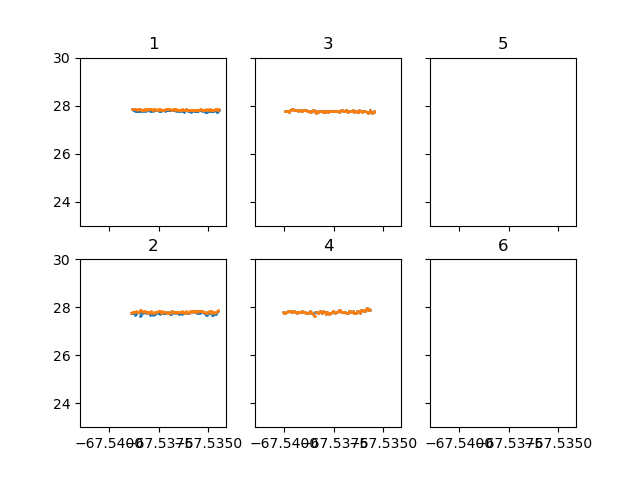

In [9]:
hf, hax=plt.subplots(2,3, sharex=True, sharey=True)
hax=hax.T.ravel()
npoints= 100
for ha, spot in zip(hax.ravel(), np.arange(1,7)):
    ii=(gdf_yapc.spot==spot) & (gdf_yapc.w_surface_window_final < 5)
    ha.plot( gdf_yapc.geometry.y[ii][0:npoints], gdf_yapc.h_mean[ii][0:npoints],'.', markersize=2)
    ii=(gdf_sea_ice_2.spot==spot) 
    ha.plot( gdf_sea_ice_2.geometry.y[ii][0:npoints], gdf_sea_ice_2.h_mean[ii][0:npoints],'.', markersize=2)
    ha.set_title(spot)

    plt.ylim(23, 30)



## Check the ATL03 classification for a subset of the region

Downloading a whole granule worth of ATL03 photons takes a lot of time and bandwidth, but it can be instructive to look at a small portion of one granule.  Here's how to look at the YAPC classification for one track for part of the granule

In [10]:
latR=[-65.25, -64.75]
lonR=[59.6, 67.7]
poly_sub=[{'lat':latR[ii], 'lon':lonR[jj]} for ii, jj in zip([1, 1, 0, 0, 1], [1, 0, 0, 1, 1])]


parms = {
    # processing parameters
    'release' :'005',
    "srt": icesat2.SRT_OCEAN,
    'time_start':'2019-05-02T02:12:24',
    'time_end':'2019-05-02T03:00:00',
    "len": 20,
    'track':1,  # select gt1l
    # classification and checks
    # still return photon segments that fail checks
    "pass_invalid": True, 
    # all photons
    "cnf": -2, 
    "yapc": dict(knn=0, win_h=6, win_x=11, min_ph=4, score=0), 
    'poly':poly_sub
}


gdf = icesat2.atl03s(parms, asset=asset,  resource='ATL03_20190502021224_05160312_005_01.h5')#granules_list)

INFO:sliderule.sliderule:request <AppServer.42739> processing initialized on ATL03_20190502021224_05160312_005_01.h5 ...
INFO:sliderule.sliderule:request <AppServer.42739> processing of ATL03_20190502021224_05160312_005_01.h5 complete (171596/0/0)
INFO:sliderule.sliderule:Successfully completed processing resource [1 out of 1]: ATL03_20190502021224_05160312_005_01.h5


In [11]:
plt.hist(gdf.yapc_score , bins= 30)

(array([16391.,  1786.,  2282.,  2239.,  2893.,  4059.,  1398.,  1180.,
         1246.,  1099.,  1394.,  2359.,   720.,   640.,   833.,   967.,
         1896.,  3133.,  2761.,  4168.,  4180.,  8260.,  5327.,  8428.,
        13542.,  7249., 10704., 16133.,  8315., 60060.]),
 array([  0.        ,   8.46666667,  16.93333333,  25.4       ,
         33.86666667,  42.33333333,  50.8       ,  59.26666667,
         67.73333333,  76.2       ,  84.66666667,  93.13333333,
        101.6       , 110.06666667, 118.53333333, 127.        ,
        135.46666667, 143.93333333, 152.4       , 160.86666667,
        169.33333333, 177.8       , 186.26666667, 194.73333333,
        203.2       , 211.66666667, 220.13333333, 228.6       ,
        237.06666667, 245.53333333, 254.        ]),
 <BarContainer object of 30 artists>)

(1100.0, 1400.0)

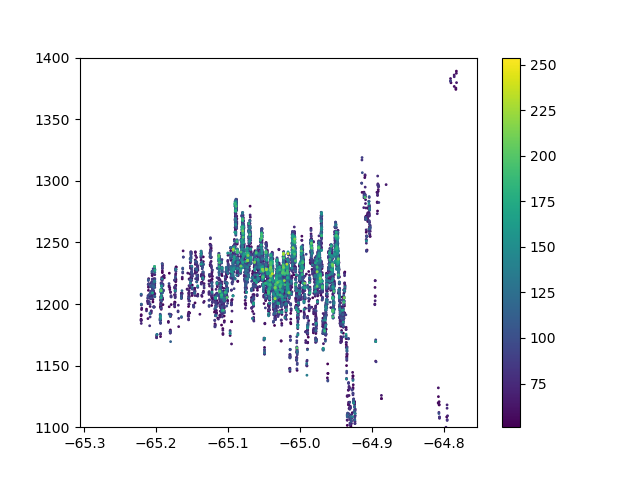

In [19]:
gdf_sel = gdf[gdf.yapc_score>50]

ii=np.argsort(gdf_sel.yapc_score)
plt.figure(); plt.scatter(gdf_sel.geometry.y[ii], gdf_sel.height[ii], 1, c=gdf_sel.yapc_score[ii])
plt.colorbar()
plt.ylim(1100, 1400)

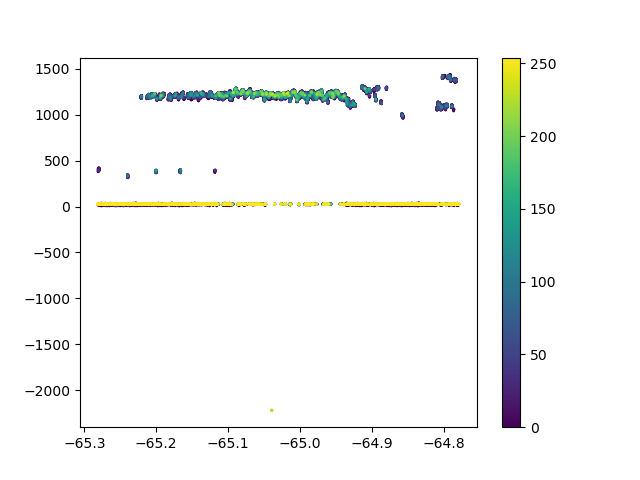

In [13]:
ii=np.argsort(gdf.yapc_score)

plt.figure(); plt.scatter(gdf.geometry.y[ii], gdf.height[ii], 1, c=gdf.yapc_score[ii])
plt.colorbar()



In [14]:
gdf_sel.geometry

time
2019-05-02 02:16:02.501539328    POINT (60.83807 -65.28112)
2019-05-02 02:16:02.501639424    POINT (60.83806 -65.28111)
2019-05-02 02:16:02.501639424    POINT (60.83806 -65.28111)
2019-05-02 02:16:02.501739264    POINT (60.83806 -65.28111)
2019-05-02 02:16:02.501839104    POINT (60.83806 -65.28110)
                                            ...            
2019-05-02 02:16:10.833439232    POINT (60.70977 -64.77884)
2019-05-02 02:16:10.833439232    POINT (60.70977 -64.77884)
2019-05-02 02:16:10.833439232    POINT (60.70977 -64.77884)
2019-05-02 02:16:10.833439232    POINT (60.70977 -64.77884)
2019-05-02 02:16:10.833439232    POINT (60.70977 -64.77884)
Name: geometry, Length: 165992, dtype: geometry

## take example from 
https://slideruleearth.io/web/rtd/api_reference/icesat2.html#atl06p

In [16]:
#from sliderule import icesat2

icesat2.init("slideruleearth.io", True)
parms = { "cnf": 4, "ats": 20.0, "cnt": 10, "len": 40.0, "res": 20.0, "maxi": 1 }
resources = ["ATL03_20181019065445_03150111_003_01.h5"]
atl03_asset = "atlas-local"
rsps = icesat2.atl06p(parms, asset=atl03_asset, resources=resources)

INFO:sliderule.sliderule:request <AppServer.42746> processing initialized on ATL03_20181019065445_03150111_003_01.h5 ...
ERROR:sliderule.sliderule:Exception <2>: H5Future read failure on /orbit_info/sc_orient: (ATL03_20181019065445_03150111_003_01.h5)
INFO:sliderule.sliderule:request <AppServer.42746> processing of ATL03_20181019065445_03150111_003_01.h5 complete (0/0/0)
INFO:sliderule.sliderule:request <AppServer.42746> processing complete (0/0/0/0)
INFO:sliderule.sliderule:Successfully completed processing resource [1 out of 1]: ATL03_20181019065445_03150111_003_01.h5


In [17]:
print(rsps)

Empty GeoDataFrame
Columns: [geometry]
Index: []
